# Loading Tracking Features into napari-clusters-plotter

In [1]:
from pathlib import Path
import napari
from napari.utils import nbscreenshot
import numpy as np
import pandas as pd
from skimage.io import imread, imsave
# from napari_clusters_plotter._plotter import PlotterWidget
from napari_skimage_regionprops import add_table
from skimage.util import map_array
from scipy.stats import rankdata
from napari_signal_selector.line import InteractiveFeaturesLineWidget


### Input paths

In [2]:
image_path = r"C:\Users\mazo260d\Desktop\Fluo-N2DL-HeLa\01.tif"
labels_path = r"C:\Users\mazo260d\Desktop\Fluo-N2DL-HeLa\01_labels.tif"
tables_folder_path = r"C:\Users\mazo260d\Desktop\Fluo-N2DL-HeLa\01_track_tables"

#### Read images

In [3]:
image_path = Path(image_path)
labels_path = Path(labels_path)
image = imread(image_path).astype('uint16')
labels = imread(labels_path).astype('uint16')
print(image.shape)

(92, 700, 1100)


In [4]:
image.dtype

dtype('uint16')

Put labels as second channel for TrackMate compatibility

In [5]:
stack = np.stack([image, labels])
stack = stack[:,:,np.newaxis]
# imsave(r"C:\Users\mazo260d\Desktop\Fluo-N2DL-HeLa\01_stack.tif", stack)
stack.shape

(2, 92, 1, 700, 1100)

In [6]:
Fiji_stack = imread(Path(r"C:\Users\mazo260d\Desktop\Fluo-N2DL-HeLa\01_Fiji_stack.tif"))
Fiji_stack.shape

(92, 2, 700, 1100)

In [7]:
intensity_image = Fiji_stack[:,0]
label_image = Fiji_stack[:,1].astype('uint16')

#### Read tables

In [8]:
tables_folder_path = Path(tables_folder_path)

table_list = []
for table_path in tables_folder_path.iterdir():
    if table_path.suffix == '.csv':
        if table_path.stem == 'edges':
            edges_table = pd.read_csv(table_path, skiprows=[1,2,3], encoding = "utf-8")
        elif table_path.stem == 'spots':
            spots_table = pd.read_csv(table_path, skiprows=[1,2,3], encoding = "utf-8")
        elif table_path.stem == 'tracks':
            tracks_table = pd.read_csv(table_path, skiprows=[1,2,3], encoding = "utf-8")


In [9]:
edges_table.head(2)

,LABEL,TRACK_ID,SPOT_SOURCE_ID,SPOT_TARGET_ID,LINK_COST,DIRECTIONAL_CHANGE_RATE,SPEED,DISPLACEMENT,EDGE_TIME,EDGE_X_LOCATION,EDGE_Y_LOCATION,EDGE_Z_LOCATION,MANUAL_EDGE_COLOR
0,ID3832 ? ID3334,0,3832,3334,16.444115,1.880772,4.055134,4.055134,27.5,892.412209,257.206236,0.0,NaN
1,ID4190 ? ID4064,0,4190,4064,1.111295,2.116685,1.054180,1.054180,29.5,890.872641,251.866069,0.0,NaN


In [10]:
spots_table.head(2)

,LABEL,ID,TRACK_ID,QUALITY,POSITION_X,POSITION_Y,POSITION_Z,POSITION_T,FRAME,RADIUS,...,ELLIPSE_Y0,ELLIPSE_MAJOR,ELLIPSE_MINOR,ELLIPSE_THETA,ELLIPSE_ASPECTRATIO,AREA,PERIMETER,CIRCULARITY,SOLIDITY,SHAPE_INDEX
0,ID2561,2561,0,427.0,900.828241,248.615942,0.0,12.0,12,11.637906,...,0.111436,13.640926,10.222635,-0.274292,1.334385,425.5,76.449589,0.914869,0.989535,3.70617
1,ID2821,2821,0,431.0,899.460694,245.828324,0.0,19.0,19,11.733244,...,0.093235,15.334853,9.309406,2.673142,1.647243,432.5,80.666810,0.835230,0.966480,3.87884


In [11]:
tracks_table.head(2)

,LABEL,TRACK_INDEX,TRACK_ID,NUMBER_SPOTS,NUMBER_GAPS,NUMBER_SPLITS,NUMBER_MERGES,NUMBER_COMPLEX,LONGEST_GAP,TRACK_DURATION,...,TRACK_MIN_SPEED,TRACK_MEDIAN_SPEED,TRACK_STD_SPEED,TRACK_MEAN_QUALITY,TOTAL_DISTANCE_TRAVELED,MAX_DISTANCE_TRAVELED,CONFINEMENT_RATIO,MEAN_STRAIGHT_LINE_SPEED,LINEARITY_OF_FORWARD_PROGRESSION,MEAN_DIRECTIONAL_CHANGE_RATE
0,Track_0,0,0,40,0,0,0,0,0,39.0,...,0.185877,2.272927,1.856671,521.425000,106.030512,15.759011,0.142069,0.386247,0.142069,1.688107
1,Track_1,1,1,213,0,4,0,0,0,91.0,...,0.226628,3.222877,3.757793,350.197183,989.719716,99.185679,0.099043,1.077198,0.230738,1.453935


## Change tables to match napari-clusters-plotter standards
Merge tracks and spots tables according to trackID

In [12]:
spots_and_tacks_table = pd.merge(left=spots_table, right=tracks_table, how='outer', on='TRACK_ID', suffixes=('_spots', '_tracks'))

In [13]:
spots_and_tacks_table

,LABEL_spots,ID,TRACK_ID,QUALITY,POSITION_X,POSITION_Y,POSITION_Z,POSITION_T,FRAME,RADIUS,...,TRACK_MIN_SPEED,TRACK_MEDIAN_SPEED,TRACK_STD_SPEED,TRACK_MEAN_QUALITY,TOTAL_DISTANCE_TRAVELED,MAX_DISTANCE_TRAVELED,CONFINEMENT_RATIO,MEAN_STRAIGHT_LINE_SPEED,LINEARITY_OF_FORWARD_PROGRESSION,MEAN_DIRECTIONAL_CHANGE_RATE
0,ID2561,2561,0,427.0,900.828241,248.615942,0.0,12.0,12,11.637906,...,0.185877,2.272927,1.856671,521.425000,106.030512,15.759011,0.142069,0.386247,0.142069,1.688107
1,ID2821,2821,0,431.0,899.460694,245.828324,0.0,19.0,19,11.733244,...,0.185877,2.272927,1.856671,521.425000,106.030512,15.759011,0.142069,0.386247,0.142069,1.688107
2,ID3334,3334,0,488.0,891.307324,255.506160,0.0,28.0,28,12.450579,...,0.185877,2.272927,1.856671,521.425000,106.030512,15.759011,0.142069,0.386247,0.142069,1.688107
3,ID4426,4426,0,647.0,895.611453,252.578657,0.0,40.0,40,14.389600,...,0.185877,2.272927,1.856671,521.425000,106.030512,15.759011,0.142069,0.386247,0.142069,1.688107
4,ID4043,4043,0,572.0,889.806818,255.602564,0.0,37.0,37,13.493452,...,0.185877,2.272927,1.856671,521.425000,106.030512,15.759011,0.142069,0.386247,0.142069,1.688107
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8663,ID10282,10282,174,206.0,255.468569,302.414806,0.0,90.0,90,8.008710,...,3.810192,9.830204,4.256791,180.666667,13.640396,12.959711,0.950098,6.479855,0.950098,0.710107
8664,ID10076,10076,174,140.0,245.730496,301.072104,0.0,89.0,89,6.699380,...,3.810192,9.830204,4.256791,180.666667,13.640396,12.959711,0.950098,6.479855,0.950098,0.710107
8665,ID10961,10961,175,101.0,641.808511,17.780142,0.0,91.0,91,5.470021,...,10.187812,14.773700,3.242712,234.333333,24.961512,24.385627,0.976929,12.192813,0.976929,0.438017
8666,ID10101,10101,175,362.0,662.879374,5.505064,0.0,89.0,89,10.734439,...,10.187812,14.773700,3.242712,234.333333,24.961512,24.385627,0.976929,12.192813,0.976929,0.438017


In [15]:
spots_table = spots_and_tacks_table

Copy some columns and rename them.
Add a 'label_unique' column and a 'label' column.

In [14]:
def move_columns_to_beginning(df: "pandas.DataFrame", columns: list[str]):
    new_columns = columns + (df.columns.drop(columns).tolist())
    return df[new_columns]

In [16]:
spots_table['original_label'] = spots_table['MEDIAN_INTENSITY_CH2'].astype(int) # Getting the original labels by the median value of the "labels channel"
spots_table['frame'] = spots_table['FRAME'].astype(int)
# Sort by frame and original label
spots_table = spots_table.sort_values(by=['frame', 'original_label'])
# Add sequential unique labels after array is sorted
spots_table['label_unique'] = spots_table.reset_index().index + 1
spots_table['label'] = rankdata(spots_table['original_label'].values, method='dense')

# move columns
spots_table = move_columns_to_beginning(spots_table, columns=['frame', 'label', 'original_label', 'label_unique', 'TRACK_ID'])
spots_table

,frame,label,original_label,label_unique,TRACK_ID,LABEL_spots,ID,QUALITY,POSITION_X,POSITION_Y,...,TRACK_MIN_SPEED,TRACK_MEDIAN_SPEED,TRACK_STD_SPEED,TRACK_MEAN_QUALITY,TOTAL_DISTANCE_TRAVELED,MAX_DISTANCE_TRAVELED,CONFINEMENT_RATIO,MEAN_STRAIGHT_LINE_SPEED,LINEARITY_OF_FORWARD_PROGRESSION,MEAN_DIRECTIONAL_CHANGE_RATE
4606,0,1,28,1,49,ID2289,2289,591.0,278.335314,300.563101,...,0.927985,2.681339,1.751411,613.750000,21.412718,8.796664,0.270795,0.828351,0.270795,0.980510
3560,0,2,203,2,37,ID2277,2277,649.0,382.143899,640.359043,...,0.434254,2.665461,2.959221,491.871795,137.283069,40.268094,0.293322,1.088327,0.301249,1.457783
4631,0,3,377,3,51,ID2346,2346,627.0,931.986343,554.761734,...,0.602828,3.423401,2.203723,649.230769,40.281591,14.256973,0.328308,1.102066,0.328308,1.743991
2975,0,4,552,4,27,ID2303,2303,600.0,120.387775,468.162768,...,0.081449,2.007569,1.697947,560.771739,212.272212,26.199743,0.123425,0.287909,0.123425,1.758727
2705,0,5,727,5,25,ID2285,2285,746.0,682.720067,20.822185,...,0.292286,2.099348,4.076754,645.704225,266.303899,31.179901,0.117084,0.820524,0.217560,1.760926
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3108,91,268,62041,8664,31,ID10683,10683,407.0,140.028053,521.415429,...,0.060942,2.913926,3.347709,327.563380,577.219094,36.356842,0.020022,0.131329,0.032092,1.741606
8662,91,269,62216,8665,174,ID10434,10434,196.0,257.991453,305.270085,...,3.810192,9.830204,4.256791,180.666667,13.640396,12.959711,0.950098,6.479855,0.950098,0.710107
8578,91,271,62740,8666,162,ID10480,10480,161.0,401.517653,303.749221,...,3.585698,7.089372,2.968952,239.857143,40.338586,14.112218,0.160632,1.619919,0.240948,2.251443
7248,91,274,64312,8667,107,ID10571,10571,158.0,529.377743,448.469697,...,0.315161,2.150246,3.202901,568.152174,149.017426,32.780265,0.070390,0.243939,0.073664,1.615779


## Remove labels from image that are not in the table ('original_labels')
These are labels whose track was excluded for some reason, so they should be removed

In [17]:
label_image2 = np.copy(label_image)
# Get label numbers that are in label image but not in spots table column "original_label"
labels_not_in_spots_table = np.setdiff1d(np.unique(label_image2), spots_table['original_label'].values)[1:]
for label in labels_not_in_spots_table:
    label_image2[label_image2 == label] = 0
    


## Relabel sequential labels in the label image according to table

In [ ]:
# Remap labels to sequential labels in a new label image
label_image2 = map_array(label_image2, spots_table['original_label'].values, spots_table['label'].values)

In [17]:
# Check that labels in image and in table column match
np.array_equal(np.unique(label_image2)[1:], np.unique(spots_table['label'].values))

True

### View in napari

In [16]:
viewer = napari.Viewer()

Assistant skips harvesting pyclesperanto as it's not installed.


In [17]:
viewer.add_image(intensity_image)

<Image layer 'intensity_image' at 0x275fbfc27c0>

In [18]:
labels_layer = viewer.add_labels(label_image2, features=spots_table)
add_table(labels_layer, viewer) # avoids current bug with status bar


Napari status bar display of label properties disabled because https://github.com/napari/napari/issues/5417 and https://github.com/napari/napari/issues/4342


In [20]:
widget = InteractiveFeaturesLineWidget(viewer)
viewer.window.add_dock_widget(widget, area='right')

c:\Users\mazo260d\mambaforge\envs\napari-sc-dev\lib\site-packages\ipykernel\eventloops.py:128: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  el.exec() if hasattr(el, 'exec') else el.exec_()


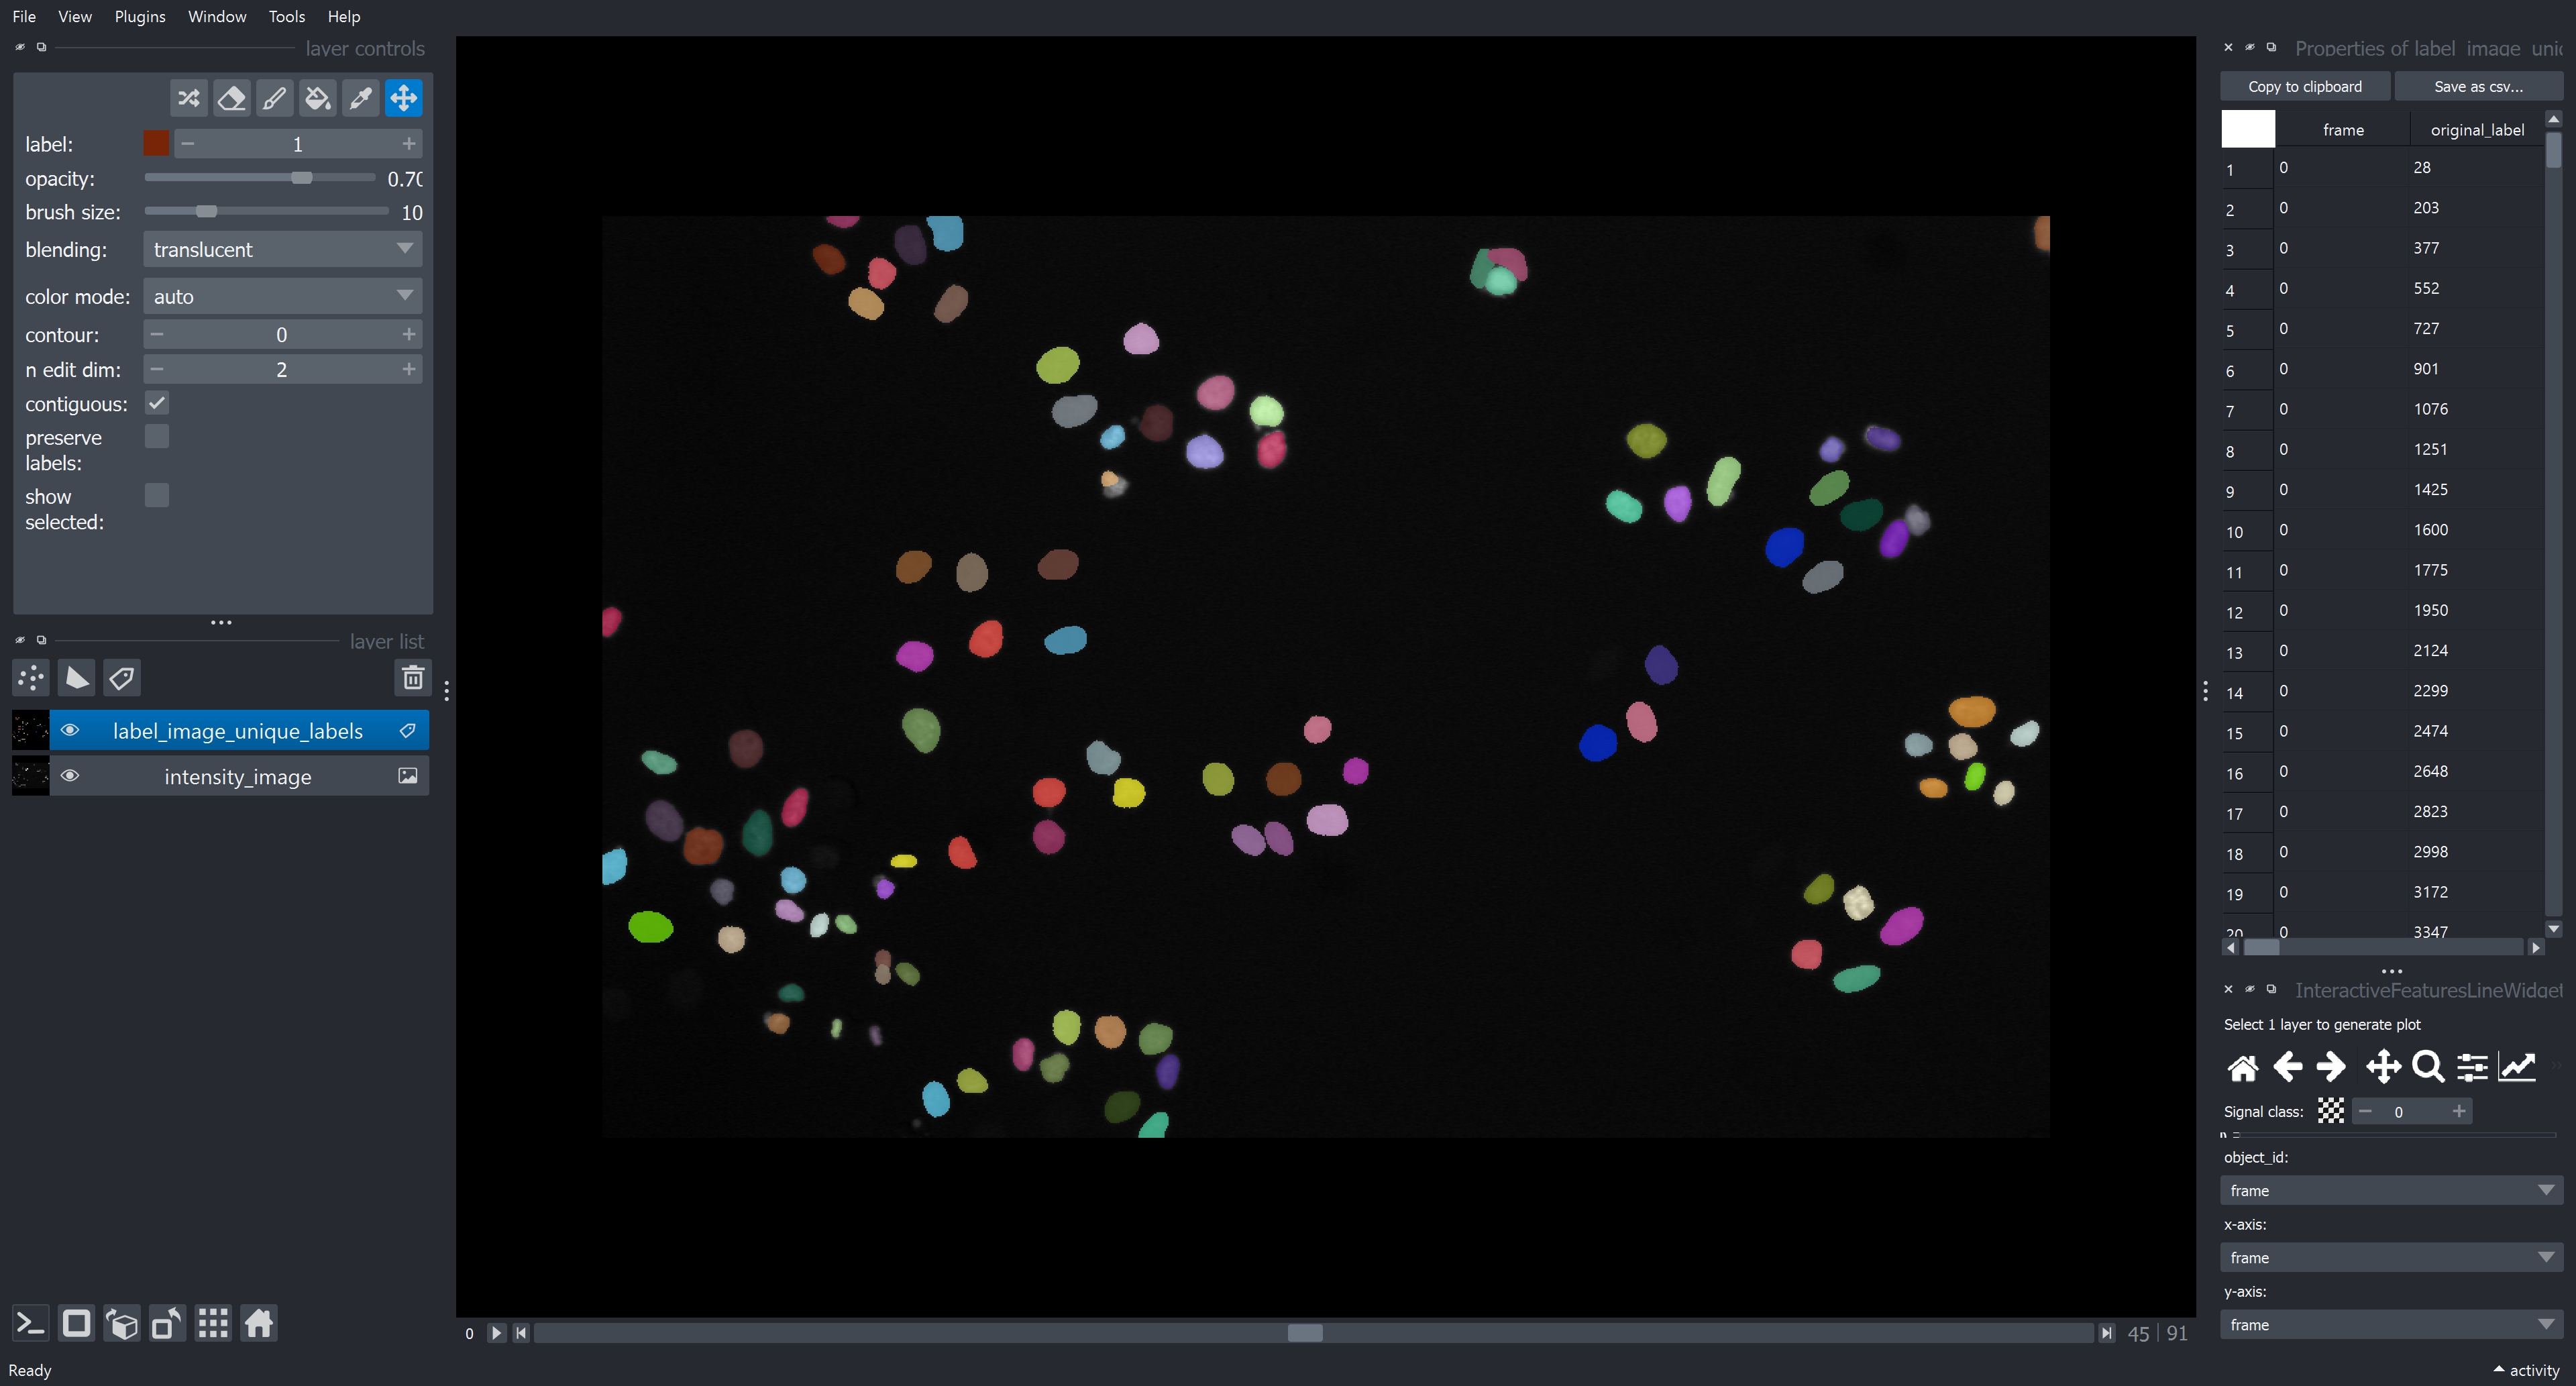

In [22]:
nbscreenshot(viewer)